# Demo of the BGTM on 2-Dimensional Joe-Copula

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 2 dimensional Joe copula.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv

# Other Stuff
import numpy as np
import torch
from torch.utils.data import DataLoader
from dataset_helpers import Generic_Dataset
import matplotlib.pyplot as plt

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading Sanity Functions

In [2]:
def sanity_check(model, use_softplus=False, transformation_grad=1):

    model_dict = dict(model.state_dict())
    print(model_dict.keys())

    if not use_softplus:
        a = model.transformation.params[transformation_grad].detach().cpu()
        eps = torch.empty_like(a)
        eps[0] = a[0]
        eps[1:] = torch.nn.functional.softplus(a[1:])
        eps = torch.cumsum(eps, dim=0)
    
    is_mono = torch.all(torch.diff(eps) > 0)
    print(is_mono.item())
        
    print(f"{eps}")  # should be strictly increasing
    plt.plot(range(len(eps)), eps, marker='o')
    plt.title("Monotonic spline coefficients ε_j,p")
    plt.xlabel("Basis index p")
    plt.ylabel("ε_j,p")
    plt.show()

def series(x):
    """Return a 1D numpy array from tensor OR list/tuple of (tensors|floats)."""
    if torch.is_tensor(x):
        return x.detach().cpu().numpy()
    if isinstance(x, (list, tuple)):
        return np.array([t.detach().cpu().item() if torch.is_tensor(t) else float(t) for t in x])
    return np.asarray(x)

#### Hyperparameter choice

In [3]:
hyperparameters = {
    "transformation": {
    "sigma_a": 2.1, "sigma_b": 1e6,        #Ignored not used
    
    #"RW2": {"tau_a": 1e-3, "tau_b": 1e-3},   # A) nearly-flat proper  ← recommended
    "RW2": {"tau_a": 1.1,  "tau_b": 1e-3},   # B) weak default
    # "RW2": {"tau_a": 1.0,  "tau_b": 1.0},    # C) unit-scale neutral
    
    "RW1": { "tau_a": 10.0,"tau_b": 15.0 }  #Ignored not used
    },
    "decorrelation": {
    "sigma_a": 2.1, "sigma_b": -1e6,              # mean σ² = very small close to 0 (weak)
    "RW2": { "tau_a": 1.5, "tau_b": 0.01 },      # E[κ2] ≈ 0.05   (weak curvature smoothing)
    "RW1": { "tau_a": 1.5, "tau_b": 0.01 },      # E[κ1] ≈ 0.10   (light shrink to linear)
    }
}

# Test 1 ndependence copula + standard Gaussian marginals (N(0,1))

### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a Independent Copula and add Gaussian marginals.
The list of copulas can be found with `help(pv.Bicop)`.

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [4]:
copula_pv = pv.Bicop(family=pv.BicopFamily.indep)


# Train
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = torch.tensor(loglik_copula) + log_marginals

copula_pv_est = pv.Bicop(family=pv.BicopFamily.indep)
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)


loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = torch.tensor(loglik_copula) + log_marginals

/tmp/ipykernel_864049/815319882.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/tmp/ipykernel_864049/815319882.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/tmp/ipykernel_864049/815319882.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_t

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [5]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=20)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=20)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [6]:
model_freq = GTM(
    number_variables = 2,
    number_transformation_layers = 1,
    number_decorrelation_layers = 0,
    degree_transformations = 10,
    degree_decorrelation = 40,
    spline_transformation = "bspline",
    spline_decorrelation = "bspline",
    transformation_spline_range = (-10, 10),
    device = "cpu") 

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            0,
                            0,
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False

# pretrain the marginal transformations
output_freq = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 0/1000 [00:00<?, ?it/s]/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:595: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  x=input_a_clone.T, t=knots.T, c=params_a.T, p=order, d=derivativ


current_loss: tensor(1.4107, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4110, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3955, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4146, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4008, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3992, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3579, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3874, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3788, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3721, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3651, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4444, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3725, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3664, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4576, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4526, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5078,

  0%|          | 1/1000 [00:01<33:07,  1.99s/it]

tensor(1.3811, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4918, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4805, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3795, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3765, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3255, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3161, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2846, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2837, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2783, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3550, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2522, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2481, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5984, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5889, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5416, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5118, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3801, grad_fn=<Mean

  0%|          | 2/1000 [00:03<31:01,  1.86s/it]

current_loss: tensor(1.2068, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2018, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6099, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6063, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5489, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5467, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5296, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3840, grad_fn=<MeanBackward0>)
current_loss: tensor(3.2423, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3476, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3427, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3366, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3476, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3800, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3338, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3205, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4301,

  0%|          | 3/1000 [00:05<29:54,  1.80s/it]

current_loss: tensor(1.3663, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3651, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3082, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3026, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2924, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2719, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3537, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3439, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2088, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6121, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6010, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5413, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6763, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5345, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3965, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3304,

  0%|          | 4/1000 [00:07<29:38,  1.79s/it]

current_loss: tensor(1.6150, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6077, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5395, grad_fn=<MeanBackward0>)
current_loss: tensor(1.9392, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5341, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3868, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3657, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3242, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3226, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3959, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3608, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3778, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3957, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3221, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3157, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3132, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4324, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4138, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3170,

  0%|          | 5/1000 [00:08<29:15,  1.76s/it]

current_loss: tensor(1.4881, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3912, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3078, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2781, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2638, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3484, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3383, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2168, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2036, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6246, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6189, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5639, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6190, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5482, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4053, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3566, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3342,

  1%|          | 6/1000 [00:10<28:52,  1.74s/it]

current_loss: tensor(1.5527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4775, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4703, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3963, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5082, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4875, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3643, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3030, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2986, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2718, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2793, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2652, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3487, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3445, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2420, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2033, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6191,

  1%|          | 7/1000 [00:12<28:35,  1.73s/it]

current_loss: tensor(1.5363, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3864, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3232, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3278, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3187, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3857, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3581, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3726, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3593, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3420, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3136, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4142, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3771, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3466, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3170, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4403, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4338, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5027,

  1%|          | 8/1000 [00:14<28:18,  1.71s/it]

current_loss: tensor(1.6241, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6196, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5648, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5605, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4163, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3961, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3814, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3431, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3269, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3026, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3149, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3043, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3340, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3302, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4660, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4035, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3135, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3132, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4620,

  1%|          | 8/1000 [00:15<32:38,  1.97s/it]

current_loss: tensor(1.3779, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3690, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2909, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2811, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2694, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2666, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3450, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3389, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2081, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2023, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6161, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6134, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5991, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5761, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5588, grad_fn=<MeanBackward0>)
Early Stop at iteration 8 with minimal loss tensor(1.5395, grad_fn=<MeanBackward0>) and patience 5 and min_delta 1e-07


The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

### 3. Hyperparameter Tune and Train Model

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [7]:
model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=0,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device="cuda" if torch.cuda.is_available() else "cpu",
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )


output = model.pretrain_transformation_layer(
                train_dataloader=dataloader_train,
                validate_dataloader=dataloader_validate,
                hyperparameters=None,
                iterations=200,
                #verbose=True,
                learning_rate=0.01,
                mcmc_sample_train=4,            # will ramp
                mcmc_sample_val=16,             # fixed & larger for stable eval
                mc_ramp_every=60,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=64,
                patience=30,                # early-stop patience
                min_delta=0.00001,                # ~0.1% absolute of your loss scale
                rho_lr_multiplier=0.1,          # slightly faster variance adaption (optional)
                sched_factor=0.7, sched_patience=12, sched_threshold=1e-4,
                #WARMING
                warm_tau_epochs = 3,
                warm_sigma_epochs = 5,  # try 5–10
                
                #Optimization method
                beta_kl_start= 3,    # try 1.5–3.0
                beta_kl_anneal_epochs = 20,  # how fast to decay to 1.0
            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Parameters to be affected by the bayesian approach: ['transformation.params.0', 'transformation.params.1']
The selected hyperparameters for the transformation layer,
 the hyperparameters lambda_a=1.100000023841858 and lambda_b=0.0010000000474974513 were selected and will by processed.
You are currently using the Full Bayesian Closed form coordinate-ascent VI (CAVI)
training only transformation layer!


  0%|          | 0/200 [00:00<?, ?it/s]

[sanity] N=2000  current B=20  (training objective uses scaled likelihood & unscaled prior)


  0%|          | 1/200 [00:19<1:05:32, 19.76s/it]

IMPROVED! Congrats
[1/200] ELBO train=8250.7283  val_ELPD=-0.2134  train_ELPD=-0.1183  S_train=4 S_val=16  lr=[0.01, 0.001]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈8.23e+03  tau4=0.747515  rank=20  E_qf_mean≈14.8  E_qf_total≈29.7  tau*E_qf≈22.2  target≈22.2  resid≈-1.65e+05    tau4_mean=0.748   Elog_tau=-0.337    â=11.1     b̂=14.8  Δ=-1.11e+04      KL(qτ||pτ)≈0.00411     β_KL=3.00  


  1%|          | 2/200 [00:38<1:04:00, 19.40s/it]

IMPROVED! Congrats
[2/200] ELBO train=15.5701  val_ELPD=-0.0737  train_ELPD=-0.0937  S_train=4 S_val=16  lr=[0.01, 0.001]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈0.717  tau4=0.988444  rank=20  E_qf_mean≈11.2  E_qf_total≈22.5  tau*E_qf≈22.2  target≈22.2  resid≈2.71    tau4_mean=0.988   Elog_tau=-0.0573    â=11.1     b̂=11.2  Δ=+2.41e-01      KL(qτ||pτ)≈0.00384     β_KL=2.90  


  2%|▏         | 3/200 [00:58<1:03:44, 19.41s/it]

IMPROVED! Congrats
[3/200] ELBO train=12.8249  val_ELPD=-0.0731  train_ELPD=-0.0714  S_train=4 S_val=16  lr=[0.01, 0.001]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈0.339  tau4=0.988827  rank=20  E_qf_mean≈11.2  E_qf_total≈22.4  tau*E_qf≈22.2  target≈22.2  resid≈0.0043    tau4_mean=0.989   Elog_tau=-0.057    â=11.1     b̂=11.2  Δ=+3.83e-04      KL(qτ||pτ)≈0.00369     β_KL=2.80  


  2%|▏         | 4/200 [01:17<1:03:18, 19.38s/it]

NOT IMPROVED! Nr. 1
[4/200] ELBO train=12.0583  val_ELPD=-0.0731  train_ELPD=-0.0711  S_train=4 S_val=16  lr=[0.01, 0.001]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈-0.162  tau4=1.06802  rank=20  E_qf_mean≈10.4  E_qf_total≈20.8  tau*E_qf≈22.2  target≈22.2  resid≈0.823    tau4_mean=1.07   Elog_tau=0.0201    â=11.1     b̂=10.4  Δ=+7.92e-02      KL(qτ||pτ)≈0.00369     β_KL=2.70  


  2%|▎         | 5/200 [01:36<1:02:53, 19.35s/it]

NOT IMPROVED! Nr. 2
[5/200] ELBO train=11.4679  val_ELPD=-0.0732  train_ELPD=-0.0711  S_train=4 S_val=16  lr=[0.01, 0.001]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈-0.602  tau4=1.17942  rank=20  E_qf_mean≈9.41  E_qf_total≈18.8  tau*E_qf≈22.2  target≈22.2  resid≈1.05    tau4_mean=1.18   Elog_tau=0.119    â=11.1     b̂=9.41  Δ=+1.11e-01      KL(qτ||pτ)≈0.00365     β_KL=2.60  


  3%|▎         | 6/200 [01:56<1:02:36, 19.36s/it]

NOT IMPROVED! Nr. 3
[6/200] ELBO train=10.7443  val_ELPD=-0.0734  train_ELPD=-0.0713  S_train=4 S_val=16  lr=[0.01, 0.001]  σ̄=0.0547 σmin=0.0547 σmax=0.0548  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈-0.987  tau4=1.32048  rank=20  E_qf_mean≈8.41  E_qf_total≈16.8  tau*E_qf≈22.2  target≈22.2  resid≈1.19    tau4_mean=1.32   Elog_tau=0.232    â=11.1     b̂=8.41  Δ=+1.41e-01      KL(qτ||pτ)≈0.00359     β_KL=2.50  


  4%|▎         | 7/200 [02:15<1:02:16, 19.36s/it]

NOT IMPROVED! Nr. 4
[7/200] ELBO train=9.9072  val_ELPD=-0.0737  train_ELPD=-0.0714  S_train=4 S_val=16  lr=[0.01, 0.001]  σ̄=0.0597 σmin=0.0597 σmax=0.0598  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈-1.33  tau4=1.48431  rank=20  E_qf_mean≈7.48  E_qf_total≈15  tau*E_qf≈22.2  target≈22.2  resid≈1.23    tau4_mean=1.48   Elog_tau=0.349    â=11.1     b̂=7.48  Δ=+1.64e-01      KL(qτ||pτ)≈0.00353     β_KL=2.40  


  4%|▍         | 8/200 [02:35<1:01:56, 19.36s/it]

NOT IMPROVED! Nr. 5
[8/200] ELBO train=9.2111  val_ELPD=-0.0741  train_ELPD=-0.0718  S_train=4 S_val=16  lr=[0.01, 0.001]  σ̄=0.0651 σmin=0.0649 σmax=0.0652  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈-1.68  tau4=1.6711  rank=20  E_qf_mean≈6.64  E_qf_total≈13.3  tau*E_qf≈22.2  target≈22.2  resid≈1.24    tau4_mean=1.67   Elog_tau=0.468    â=11.1     b̂=6.64  Δ=+1.87e-01      KL(qτ||pτ)≈0.00347     β_KL=2.30  


  4%|▍         | 9/200 [02:54<1:01:37, 19.36s/it]

NOT IMPROVED! Nr. 6
[9/200] ELBO train=8.5237  val_ELPD=-0.0746  train_ELPD=-0.0721  S_train=4 S_val=16  lr=[0.01, 0.001]  σ̄=0.0708 σmin=0.0703 σmax=0.0710  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈-2.03  tau4=1.85935  rank=20  E_qf_mean≈5.97  E_qf_total≈11.9  tau*E_qf≈22.2  target≈22.2  resid≈1.12    tau4_mean=1.86   Elog_tau=0.575    â=11.1     b̂=5.97  Δ=+1.88e-01      KL(qτ||pτ)≈0.0034     β_KL=2.20  


  5%|▌         | 10/200 [03:13<1:01:28, 19.41s/it]

NOT IMPROVED! Nr. 7
[10/200] ELBO train=7.8877  val_ELPD=-0.0752  train_ELPD=-0.0726  S_train=4 S_val=16  lr=[0.01, 0.001]  σ̄=0.0769 σmin=0.0761 σmax=0.0772  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈-2.39  tau4=2.0139  rank=20  E_qf_mean≈5.51  E_qf_total≈11  tau*E_qf≈22.2  target≈22.2  resid≈0.852    tau4_mean=2.01   Elog_tau=0.654    â=11.1     b̂=5.51  Δ=+1.55e-01      KL(qτ||pτ)≈0.00334     β_KL=2.10  


  6%|▌         | 11/200 [03:33<1:00:54, 19.34s/it]

NOT IMPROVED! Nr. 8
[11/200] ELBO train=7.2169  val_ELPD=-0.0758  train_ELPD=-0.0731  S_train=4 S_val=16  lr=[0.01, 0.001]  σ̄=0.0833 σmin=0.0821 σmax=0.0838  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈-2.75  tau4=2.0972  rank=20  E_qf_mean≈5.29  E_qf_total≈10.6  tau*E_qf≈22.2  target≈22.2  resid≈0.441    tau4_mean=2.1   Elog_tau=0.695    â=11.1     b̂=5.29  Δ=+8.33e-02      KL(qτ||pτ)≈0.0033     β_KL=2.00  


  6%|▌         | 12/200 [03:52<1:00:36, 19.34s/it]

NOT IMPROVED! Nr. 9
[12/200] ELBO train=6.5980  val_ELPD=-0.0765  train_ELPD=-0.0737  S_train=4 S_val=16  lr=[0.01, 0.001]  σ̄=0.0901 σmin=0.0883 σmax=0.0908  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈-3.1  tau4=2.07563  rank=20  E_qf_mean≈5.35  E_qf_total≈10.7  tau*E_qf≈22.2  target≈22.2  resid≈-0.115    tau4_mean=2.08   Elog_tau=0.685    â=11.1     b̂=5.35  Δ=-2.16e-02      KL(qτ||pτ)≈0.00328     β_KL=1.90  


  6%|▋         | 13/200 [04:12<1:00:54, 19.54s/it]

NOT IMPROVED! Nr. 10
[13/200] ELBO train=6.0194  val_ELPD=-0.0770  train_ELPD=-0.0743  S_train=4 S_val=16  lr=[0.01, 0.001]  σ̄=0.0970 σmin=0.0938 σmax=0.0981  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈-3.46  tau4=1.94526  rank=20  E_qf_mean≈5.71  E_qf_total≈11.4  tau*E_qf≈22.2  target≈22.2  resid≈-0.744    tau4_mean=1.95   Elog_tau=0.62    â=11.1     b̂=5.71  Δ=-1.30e-01      KL(qτ||pτ)≈0.00328     β_KL=1.80  


  7%|▋         | 14/200 [04:32<1:00:56, 19.66s/it]

NOT IMPROVED! Nr. 11
[14/200] ELBO train=5.4507  val_ELPD=-0.0775  train_ELPD=-0.0746  S_train=4 S_val=16  lr=[0.01, 0.001]  σ̄=0.1042 σmin=0.0996 σmax=0.1058  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈-3.79  tau4=1.74735  rank=20  E_qf_mean≈6.35  E_qf_total≈12.7  tau*E_qf≈22.2  target≈22.2  resid≈-1.26    tau4_mean=1.75   Elog_tau=0.512    â=11.1     b̂=6.35  Δ=-1.98e-01      KL(qτ||pτ)≈0.00332     β_KL=1.70  


  8%|▊         | 15/200 [04:59<1:07:41, 21.96s/it]

NOT IMPROVED! Nr. 12
[15/200] ELBO train=4.9823  val_ELPD=-0.0778  train_ELPD=-0.0751  S_train=4 S_val=16  lr=[0.01, 0.001]  σ̄=0.1114 σmin=0.1055 σmax=0.1138  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈-4.1  tau4=1.53353  rank=20  E_qf_mean≈7.24  E_qf_total≈14.5  tau*E_qf≈22.2  target≈22.2  resid≈-1.55    tau4_mean=1.53   Elog_tau=0.382    â=11.1     b̂=7.24  Δ=-2.14e-01      KL(qτ||pτ)≈0.00338     β_KL=1.60  


  8%|▊         | 16/200 [05:21<1:07:25, 21.98s/it]

NOT IMPROVED! Nr. 13
[16/200] ELBO train=4.5158  val_ELPD=-0.0781  train_ELPD=-0.0753  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0007]  σ̄=0.1187 σmin=0.1100 σmax=0.1221  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈-4.37  tau4=1.3362  rank=20  E_qf_mean≈8.31  E_qf_total≈16.6  tau*E_qf≈22.2  target≈22.2  resid≈-1.64    tau4_mean=1.34   Elog_tau=0.244    â=11.1     b̂=8.31  Δ=-1.97e-01      KL(qτ||pτ)≈0.00345     β_KL=1.50  


  8%|▊         | 17/200 [05:40<1:04:32, 21.16s/it]

NOT IMPROVED! Nr. 14
[17/200] ELBO train=4.1222  val_ELPD=-0.0781  train_ELPD=-0.0751  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0007]  σ̄=0.1240 σmin=0.1139 σmax=0.1280  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈-4.58  tau4=1.1903  rank=20  E_qf_mean≈9.32  E_qf_total≈18.6  tau*E_qf≈22.2  target≈22.2  resid≈-1.36    tau4_mean=1.19   Elog_tau=0.128    â=11.1     b̂=9.33  Δ=-1.46e-01      KL(qτ||pτ)≈0.00353     β_KL=1.40  


  9%|▉         | 18/200 [06:01<1:03:20, 20.88s/it]

NOT IMPROVED! Nr. 15
[18/200] ELBO train=3.8257  val_ELPD=-0.0785  train_ELPD=-0.0755  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0007]  σ̄=0.1290 σmin=0.1171 σmax=0.1340  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈-4.74  tau4=1.08021  rank=20  E_qf_mean≈10.3  E_qf_total≈20.5  tau*E_qf≈22.2  target≈22.2  resid≈-1.13    tau4_mean=1.08   Elog_tau=0.0314    â=11.1     b̂=10.3  Δ=-1.10e-01      KL(qτ||pτ)≈0.00359     β_KL=1.30  


 10%|▉         | 19/200 [06:20<1:01:32, 20.40s/it]

NOT IMPROVED! Nr. 16
[19/200] ELBO train=3.5566  val_ELPD=-0.0785  train_ELPD=-0.0756  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0007]  σ̄=0.1338 σmin=0.1202 σmax=0.1400  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈-4.87  tau4=0.984181  rank=20  E_qf_mean≈11.3  E_qf_total≈22.6  tau*E_qf≈22.2  target≈22.2  resid≈-1.08    tau4_mean=0.984   Elog_tau=-0.0617    â=11.1     b̂=11.3  Δ=-9.60e-02      KL(qτ||pτ)≈0.00364     β_KL=1.20  


 10%|█         | 20/200 [06:39<1:00:05, 20.03s/it]

NOT IMPROVED! Nr. 17
[20/200] ELBO train=3.3612  val_ELPD=-0.0787  train_ELPD=-0.0756  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0007]  σ̄=0.1386 σmin=0.1224 σmax=0.1459  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈-4.99  tau4=0.901172  rank=20  E_qf_mean≈12.3  E_qf_total≈24.6  tau*E_qf≈22.2  target≈22.2  resid≈-1.02    tau4_mean=0.901   Elog_tau=-0.15    â=11.1     b̂=12.3  Δ=-8.30e-02      KL(qτ||pτ)≈0.00369     β_KL=1.10  


 10%|█         | 21/200 [06:58<59:00, 19.78s/it]  

NOT IMPROVED! Nr. 18
[21/200] ELBO train=3.1653  val_ELPD=-0.0787  train_ELPD=-0.0759  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0007]  σ̄=0.1429 σmin=0.1240 σmax=0.1517  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈-5.1  tau4=0.827538  rank=20  E_qf_mean≈13.4  E_qf_total≈26.8  tau*E_qf≈22.2  target≈22.2  resid≈-0.988    tau4_mean=0.828   Elog_tau=-0.235    â=11.1     b̂=13.4  Δ=-7.36e-02      KL(qτ||pτ)≈0.00374     β_KL=1.00  


 11%|█         | 22/200 [07:18<58:07, 19.60s/it]

NOT IMPROVED! Nr. 19
[22/200] ELBO train=3.0068  val_ELPD=-0.0787  train_ELPD=-0.0758  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0007]  σ̄=0.1474 σmin=0.1260 σmax=0.1578  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈-5.19  tau4=0.762066  rank=20  E_qf_mean≈14.6  E_qf_total≈29.1  tau*E_qf≈22.2  target≈22.2  resid≈-0.954    tau4_mean=0.762   Elog_tau=-0.317    â=11.1     b̂=14.6  Δ=-6.55e-02      KL(qτ||pτ)≈0.00379     β_KL=1.00  


 12%|█▏        | 23/200 [07:37<57:51, 19.62s/it]

NOT IMPROVED! Nr. 20
[23/200] ELBO train=2.8742  val_ELPD=-0.0789  train_ELPD=-0.0759  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0007]  σ̄=0.1522 σmin=0.1273 σmax=0.1644  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈-5.29  tau4=0.702261  rank=20  E_qf_mean≈15.8  E_qf_total≈31.6  tau*E_qf≈22.2  target≈22.2  resid≈-0.945    tau4_mean=0.702   Elog_tau=-0.399    â=11.1     b̂=15.8  Δ=-5.98e-02      KL(qτ||pτ)≈0.00383     β_KL=1.00  


 12%|█▏        | 24/200 [07:58<58:27, 19.93s/it]

NOT IMPROVED! Nr. 21
[24/200] ELBO train=2.7703  val_ELPD=-0.0789  train_ELPD=-0.0760  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0007]  σ̄=0.1573 σmin=0.1285 σmax=0.1715  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈-5.38  tau4=0.649128  rank=20  E_qf_mean≈17.1  E_qf_total≈34.2  tau*E_qf≈22.2  target≈22.2  resid≈-0.909    tau4_mean=0.649   Elog_tau=-0.478    â=11.1     b̂=17.1  Δ=-5.31e-02      KL(qτ||pτ)≈0.00388     β_KL=1.00  


 12%|█▎        | 25/200 [08:18<58:00, 19.89s/it]

NOT IMPROVED! Nr. 22
[25/200] ELBO train=2.6492  val_ELPD=-0.0790  train_ELPD=-0.0759  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0007]  σ̄=0.1627 σmin=0.1292 σmax=0.1790  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈-5.46  tau4=0.601779  rank=20  E_qf_mean≈18.4  E_qf_total≈36.9  tau*E_qf≈22.2  target≈22.2  resid≈-0.873    tau4_mean=0.602   Elog_tau=-0.554    â=11.1     b̂=18.4  Δ=-4.73e-02      KL(qτ||pτ)≈0.00392     β_KL=1.00  


 13%|█▎        | 26/200 [08:49<1:07:32, 23.29s/it]

NOT IMPROVED! Nr. 23
[26/200] ELBO train=2.5416  val_ELPD=-0.0790  train_ELPD=-0.0759  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0007]  σ̄=0.1684 σmin=0.1312 σmax=0.1869  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈-5.55  tau4=0.561271  rank=20  E_qf_mean≈19.8  E_qf_total≈39.6  tau*E_qf≈22.2  target≈22.2  resid≈-0.801    tau4_mean=0.561   Elog_tau=-0.623    â=11.1     b̂=19.8  Δ=-4.05e-02      KL(qτ||pτ)≈0.00396     β_KL=1.00  


 14%|█▎        | 27/200 [09:18<1:11:50, 24.91s/it]

NOT IMPROVED! Nr. 24
[27/200] ELBO train=2.4268  val_ELPD=-0.0790  train_ELPD=-0.0764  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0007]  σ̄=0.1739 σmin=0.1316 σmax=0.1953  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈-5.62  tau4=0.527309  rank=20  E_qf_mean≈21  E_qf_total≈42.1  tau*E_qf≈22.2  target≈22.2  resid≈-0.715    tau4_mean=0.527   Elog_tau=-0.686    â=11.1     b̂=21.1  Δ=-3.40e-02      KL(qτ||pτ)≈0.004     β_KL=1.00  


 14%|█▍        | 28/200 [09:38<1:07:14, 23.45s/it]

NOT IMPROVED! Nr. 25
[28/200] ELBO train=2.3098  val_ELPD=-0.0791  train_ELPD=-0.0762  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0007]  σ̄=0.1795 σmin=0.1324 σmax=0.2040  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈-5.7  tau4=0.500883  rank=20  E_qf_mean≈22.2  E_qf_total≈44.3  tau*E_qf≈22.2  target≈22.2  resid≈-0.586    tau4_mean=0.501   Elog_tau=-0.737    â=11.1     b̂=22.2  Δ=-2.64e-02      KL(qτ||pτ)≈0.00404     β_KL=1.00  


 14%|█▍        | 29/200 [09:58<1:04:19, 22.57s/it]

NOT IMPROVED! Nr. 26
[29/200] ELBO train=2.2124  val_ELPD=-0.0792  train_ELPD=-0.0761  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0007]  σ̄=0.1859 σmin=0.1318 σmax=0.2134  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈-5.76  tau4=0.478842  rank=20  E_qf_mean≈23.2  E_qf_total≈46.4  tau*E_qf≈22.2  target≈22.2  resid≈-0.511    tau4_mean=0.479   Elog_tau=-0.782    â=11.1     b̂=23.2  Δ=-2.20e-02      KL(qτ||pτ)≈0.00406     β_KL=1.00  


 15%|█▌        | 30/200 [10:36<1:17:11, 27.24s/it]

NOT IMPROVED! Nr. 27
[30/200] ELBO train=2.1285  val_ELPD=-0.0792  train_ELPD=-0.0763  S_train=4 S_val=16  lr=[0.004899999999999999, 0.00049]  σ̄=0.1921 σmin=0.1326 σmax=0.2232  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈-5.82  tau4=0.460341  rank=20  E_qf_mean≈24.1  E_qf_total≈48.2  tau*E_qf≈22.2  target≈22.2  resid≈-0.446    tau4_mean=0.46   Elog_tau=-0.822    â=11.1     b̂=24.1  Δ=-1.85e-02      KL(qτ||pτ)≈0.00409     β_KL=1.00  


 16%|█▌        | 31/200 [10:58<1:12:07, 25.61s/it]

NOT IMPROVED! Nr. 28
[31/200] ELBO train=2.0609  val_ELPD=-0.0793  train_ELPD=-0.0764  S_train=4 S_val=16  lr=[0.004899999999999999, 0.00049]  σ̄=0.1968 σmin=0.1333 σmax=0.2304  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈-5.87  tau4=0.4473  rank=20  E_qf_mean≈24.8  E_qf_total≈49.6  tau*E_qf≈22.2  target≈22.2  resid≈-0.324    tau4_mean=0.447   Elog_tau=-0.85    â=11.1     b̂=24.8  Δ=-1.30e-02      KL(qτ||pτ)≈0.00411     β_KL=1.00  


 16%|█▌        | 32/200 [11:17<1:06:17, 23.68s/it]

NOT IMPROVED! Nr. 29
[32/200] ELBO train=1.9463  val_ELPD=-0.0792  train_ELPD=-0.0761  S_train=4 S_val=16  lr=[0.004899999999999999, 0.00049]  σ̄=0.2017 σmin=0.1342 σmax=0.2380  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈-5.91  tau4=0.435988  rank=20  E_qf_mean≈25.5  E_qf_total≈50.9  tau*E_qf≈22.2  target≈22.2  resid≈-0.288    tau4_mean=0.436   Elog_tau=-0.876    â=11.1     b̂=25.5  Δ=-1.13e-02      KL(qτ||pτ)≈0.00413     β_KL=1.00  


 16%|█▌        | 32/200 [11:43<1:01:31, 21.97s/it]

NOT IMPROVED! Nr. 30
[33/200] ELBO train=1.9178  val_ELPD=-0.0793  train_ELPD=-0.0763  S_train=4 S_val=16  lr=[0.004899999999999999, 0.00049]  σ̄=0.2067 σmin=0.1343 σmax=0.2459  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈-5.95  tau4=0.425771  rank=20  E_qf_mean≈26.1  E_qf_total≈52.1  tau*E_qf≈22.2  target≈22.2  resid≈-0.266    tau4_mean=0.426   Elog_tau=-0.9    â=11.1     b̂=26.1  Δ=-1.02e-02      KL(qτ||pτ)≈0.00414     β_KL=1.00  
Early stop @ epoch 33: no val improvement for 30 epochs.


In [8]:
print(model_freq.transformation.params[0])
print(model.transformation.params[0])

print(len(model_freq.transformation.params[0]))
print(len(model.transformation.params[0]))


print(model_freq.transformation.params[1])
print(model.transformation.params[1])

print(len(model_freq.transformation.params[1]))
print(len(model.transformation.params[1]))

Parameter containing:
tensor([-10.0817,   1.5565,   1.5565,   1.5565,   1.5544,   1.8326,   2.3122,
          1.8664,   1.6476,   1.6411,   1.6411,   1.6411], requires_grad=True)
Parameter containing:
tensor([-9.0003, -0.0682,  2.0680,  1.7683,  1.1899,  1.3751,  2.3235,  2.0072,
        -1.4318, -2.1197, -2.0315, -1.8895], device='cuda:0',
       requires_grad=True)
12
12
Parameter containing:
tensor([-10.0785,   1.5649,   1.5649,   1.5649,   1.5852,   1.9659,   2.2670,
          1.9151,   1.6499,   1.6411,   1.6411,   1.6411], requires_grad=True)
Parameter containing:
tensor([-8.9967, -0.0751,  2.0621,  1.7457,  1.1587,  1.3713,  2.1896,  1.8975,
        -1.4864, -2.1927, -2.1374, -1.9893], device='cuda:0',
       requires_grad=True)
12
12


FREQ
dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-10.0817,  -8.3338,  -6.5860,  -4.8381,  -3.0920,  -1.1110,   1.2956,
          3.3058,   5.1295,   6.9477,   8.7658,  10.5840])


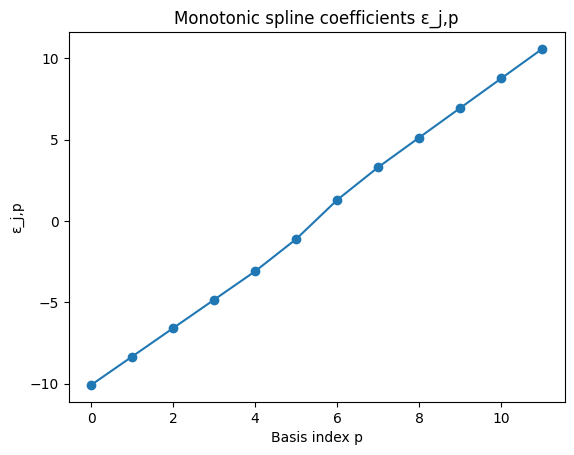

BAY
dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-9.0003, -8.3407, -6.1536, -4.2277, -2.7722, -1.1717,  1.2453,  3.3785,
         3.5927,  3.7061,  3.8294,  3.9701])


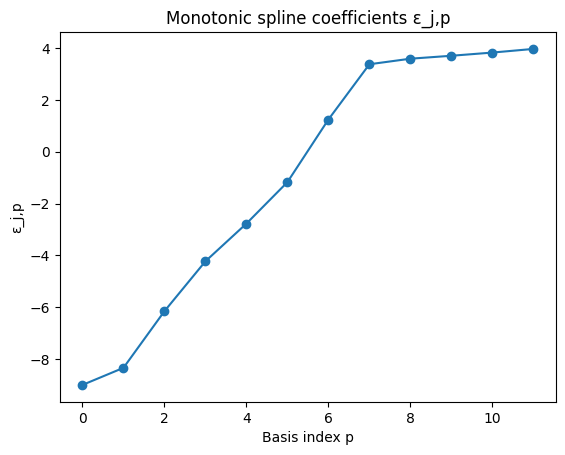

FREQ
dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-10.0785,  -8.3238,  -6.5690,  -4.8143,  -3.0426,  -0.9457,   1.4199,
          3.4724,   5.2980,   7.1163,   8.9345,  10.7527])


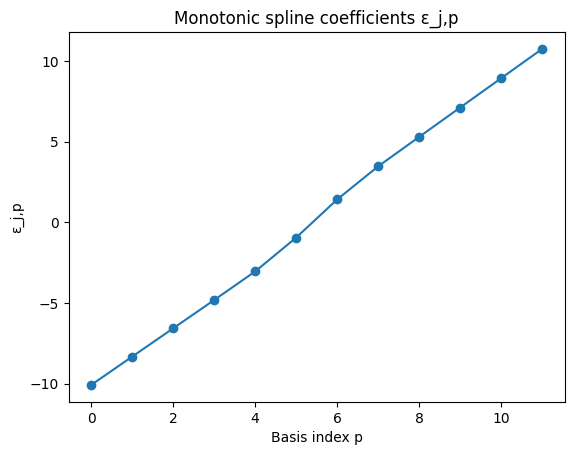

BAY
dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-8.9967, -8.3404, -6.1585, -4.2520, -2.8203, -1.2228,  1.0730,  3.1102,
         3.3141,  3.4199,  3.5314,  3.6596])


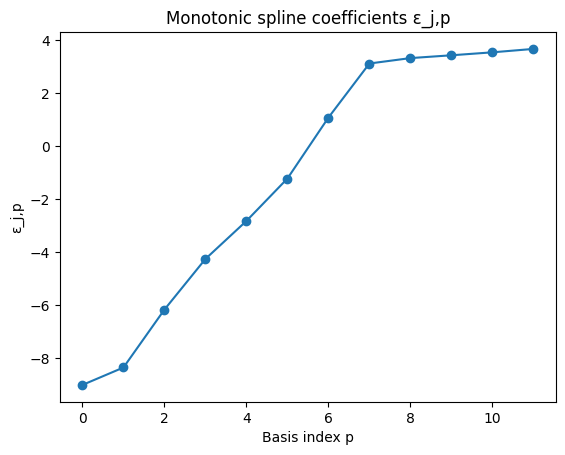

In [9]:
print("FREQ")
sanity_check(model_freq, transformation_grad=0)
print("BAY")
sanity_check(model, transformation_grad=0)
print("FREQ")
sanity_check(model_freq, transformation_grad=1)
print("BAY")
sanity_check(model, transformation_grad=1)

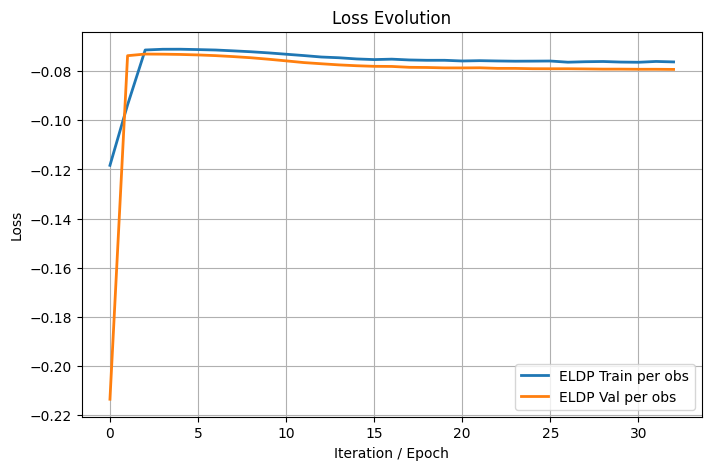

In [10]:
elbo= output['loss_history']
loss_history = output['ll_history']
val_loss = output['val_history']
mean_log_q = output['mean_log_q']
mean_log_p_tilde = output['mean_log_p_tilde']


# Plot            
plt.figure(figsize=(8, 5))
#plt.plot(mean_log_q, label= "mean_log_q per obs")
#plt.plot(mean_log_p_tilde, label= "mean_log_p_tilde per obs")
#plt.plot(elbo, label= "ELBO per obs")
plt.plot(loss_history, label="ELDP Train per obs", linewidth=2)
plt.plot(val_loss, label="ELDP Val per obs", linewidth=2)
plt.xlabel("Iteration / Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
print(
    "freq_model nr. parameters", sum(p.numel() for p in model_freq.parameters() if p.requires_grad),
    "bay_model nr. parameters", sum(p.numel() for p in model.parameters() if p.requires_grad))

print("VI Model params = ",output['mu'])
print("BGTM params = ",[p for p in model.parameters() if p.requires_grad])
print("GTMp params = ",[p for p in model_freq.parameters() if p.requires_grad])

freq_model nr. parameters 24 bay_model nr. parameters 24
VI Model params =  tensor([-9.0003, -0.0682,  2.0680,  1.7683,  1.1899,  1.3751,  2.3235,  2.0072,
        -1.4318, -2.1197, -2.0315, -1.8895, -8.9967, -0.0751,  2.0621,  1.7457,
         1.1587,  1.3713,  2.1896,  1.8975, -1.4864, -2.1927, -2.1374, -1.9893],
       device='cuda:0')
BGTM params =  [Parameter containing:
tensor([-9.0003, -0.0682,  2.0680,  1.7683,  1.1899,  1.3751,  2.3235,  2.0072,
        -1.4318, -2.1197, -2.0315, -1.8895], device='cuda:0',
       requires_grad=True), Parameter containing:
tensor([-8.9967, -0.0751,  2.0621,  1.7457,  1.1587,  1.3713,  2.1896,  1.8975,
        -1.4864, -2.1927, -2.1374, -1.9893], device='cuda:0',
       requires_grad=True)]
GTMp params =  [Parameter containing:
tensor([-10.0817,   1.5565,   1.5565,   1.5565,   1.5544,   1.8326,   2.3122,
          1.8664,   1.6476,   1.6411,   1.6411,   1.6411], requires_grad=True), Parameter containing:
tensor([-10.0785,   1.5649,   1.5649,   1

### 4. Compare to Benchmarks

We compare the learned GTM to a Gaussian Approximation and the Oracle Model. We expect the GTM to lie between these two in terms of approximation the true underlying distribution.
We measure this by means of the Kullback Leibler Divergence which we approximate on the test set which is equivalent to the log likelihood ratio between the true distribution and an approximation of it..

In [12]:
log_likelihood_train_bgtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_bgtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_bgtm = model.log_likelihood(simulated_data_test)


log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [13]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)


In [14]:
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("")
print("KLD BGTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM      Train Data:  0.0189
KLD GTM      Train Data:  0.0367
KLD Gaussian Train Data:  -0.0004
KLD Copula   Train Data:  -0.0001

KLD BGTM      Test  Data:  0.0163
KLD GTM      Test  Data:  0.0326
KLD Gaussian Test  Data:  0.0002
KLD Copula   Test  Data:  0.001


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as the model splines.

Note that to generate synthetic samples the inverse of the trainsformation layer needs to be approximated  with the method `approximate_transformation_inverse` once which is then stored for future sampling. 

In [15]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)
model_freq.approximate_transformation_inverse()
synthetic_samples_freq = model_freq.sample(10000)

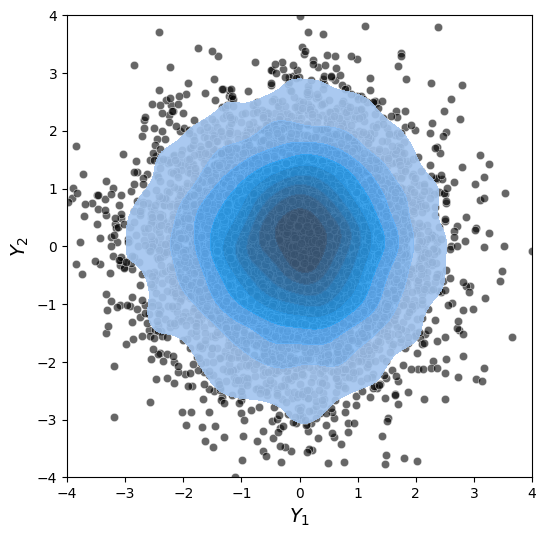

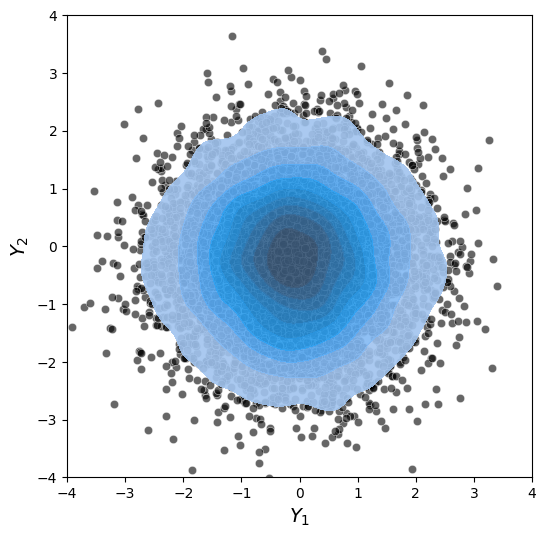

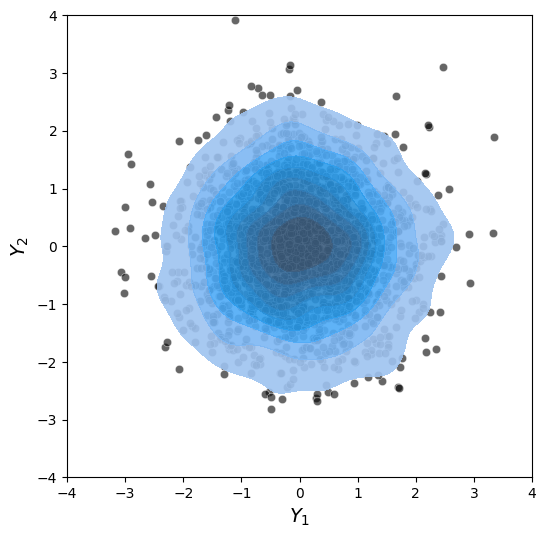

In [16]:
model.plot_densities(synthetic_samples.cpu().numpy(), x_lim=[-4,4], y_lim=[-4,4])
model_freq.plot_densities(synthetic_samples_freq, x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

The varying pseudo conditional correlation matrix values can be computed for any synthetic samples using `compute_pseudo_conditional_correlation_matrix` or can directly be plotted using `plot_conditional_dependence_structure`.
The pseudo conditional correlation matrix is the standardised precision matrix so that off diagonal elements are the pseudo conditional correlations between the respective dimensions.

# Test 2
Independence copula + shifted/scaled Gaussian marginals (N(μ, σ²))

In [17]:
# User-chosen marginal parameters
mu = torch.tensor([1.5, -0.7], dtype=torch.float32)
sigma = torch.tensor([1.8, 0.6], dtype=torch.float32)  # stds

# ---------- Copula ----------
copula_pv = pv.Bicop(family=pv.BicopFamily.indep)

# ---------- Train ----------
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
# Transform uniforms to shifted/scaled Gaussians
Z_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()
simulated_data_train = mu + sigma * Z_train

# ---------- Validate ----------
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
Z_val = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()
simulated_data_validate = mu + sigma * Z_val

# ---------- Test ----------
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
Z_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()
simulated_data_test = mu + sigma * Z_test

# ---------- "True" log-likelihoods under independence + N(mu, sigma^2) ----------
loglik_true_train = torch.distributions.Normal(mu, sigma).log_prob(simulated_data_train).sum(1)
loglik_true_validate = torch.distributions.Normal(mu, sigma).log_prob(simulated_data_validate).sum(1)
loglik_true_test = torch.distributions.Normal(mu, sigma).log_prob(simulated_data_test).sum(1)

# ---------- "Estimated" marginals from train (fit μ, σ from train) ----------
means = simulated_data_train.mean(0)
stds  = simulated_data_train.std(0, unbiased=True)

loglik_true_est_train = torch.distributions.Normal(means, stds).log_prob(simulated_data_train).sum(1)
loglik_true_est_validate = torch.distributions.Normal(means, stds).log_prob(simulated_data_validate).sum(1)
loglik_true_est_test = torch.distributions.Normal(means, stds).log_prob(simulated_data_test).sum(1)

# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=20)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=20)

### BGTM model

In [18]:
model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=0,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device="cuda" if torch.cuda.is_available() else "cpu",
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

model.transform_only = True

output = model.pretrain_transformation_layer(
                train_dataloader=dataloader_train,
                validate_dataloader=dataloader_validate,
                hyperparameters=None,
                iterations=200,
                #verbose=True,
                learning_rate=0.01,
                mcmc_sample_train=4,            # will ramp
                mcmc_sample_val=16,             # fixed & larger for stable eval
                mc_ramp_every=60,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=64,
                patience=30,                # early-stop patience
                min_delta=0.00001,                # ~0.1% absolute of your loss scale
                rho_lr_multiplier=0.5,          # slightly faster variance adaption (optional)
                sched_factor=0.7, sched_patience=12, sched_threshold=1e-4,
                #WARMING
                warm_tau_epochs = 3,
                warm_sigma_epochs = 10,  # try 5–10
                #Optimization method
                beta_kl_start= 1.5,    # try 1.5–3.0
                beta_kl_anneal_epochs = 15,  # how fast to decay to 1.0
            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Parameters to be affected by the bayesian approach: ['transformation.params.0', 'transformation.params.1']
The selected hyperparameters for the transformation layer,
 the hyperparameters lambda_a=1.100000023841858 and lambda_b=0.0010000000474974513 were selected and will by processed.
You are currently using the Full Bayesian Closed form coordinate-ascent VI (CAVI)
training only transformation layer!


  0%|          | 0/200 [00:00<?, ?it/s]

[sanity] N=2000  current B=20  (training objective uses scaled likelihood & unscaled prior)


  0%|          | 1/200 [00:20<1:07:26, 20.34s/it]

IMPROVED! Congrats
[1/200] ELBO train=8250.6450  val_ELPD=-0.2196  train_ELPD=-0.1348  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈8.23e+03  tau4=0.747413  rank=20  E_qf_mean≈14.9  E_qf_total≈29.7  tau*E_qf≈22.2  target≈22.2  resid≈-1.65e+05    tau4_mean=0.747   Elog_tau=-0.337    â=11.1     b̂=14.9  Δ=-1.11e+04      KL(qτ||pτ)≈0.00411     β_KL=1.50  


  1%|          | 2/200 [00:39<1:04:53, 19.66s/it]

IMPROVED! Congrats
[2/200] ELBO train=13.3639  val_ELPD=-0.0775  train_ELPD=-0.0990  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈0.686  tau4=1.00364  rank=20  E_qf_mean≈11.1  E_qf_total≈22.1  tau*E_qf≈22.2  target≈22.2  resid≈2.83    tau4_mean=1   Elog_tau=-0.0421    â=11.1     b̂=11.1  Δ=+2.56e-01      KL(qτ||pτ)≈0.00384     β_KL=1.47  


  2%|▏         | 3/200 [00:59<1:04:52, 19.76s/it]

IMPROVED! Congrats
[3/200] ELBO train=10.6674  val_ELPD=-0.0751  train_ELPD=-0.0760  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈0.327  tau4=1.04772  rank=20  E_qf_mean≈10.6  E_qf_total≈21.2  tau*E_qf≈22.2  target≈22.2  resid≈0.467    tau4_mean=1.05   Elog_tau=0.000898    â=11.1     b̂=10.6  Δ=+4.41e-02      KL(qτ||pτ)≈0.00368     β_KL=1.43  


  2%|▏         | 4/200 [01:37<1:27:33, 26.81s/it]

IMPROVED! Congrats
[4/200] ELBO train=9.9475  val_ELPD=-0.0745  train_ELPD=-0.0747  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈-0.177  tau4=1.14941  rank=20  E_qf_mean≈9.66  E_qf_total≈19.3  tau*E_qf≈22.2  target≈22.2  resid≈0.982    tau4_mean=1.15   Elog_tau=0.0935    â=11.1     b̂=9.66  Δ=+1.02e-01      KL(qτ||pτ)≈0.00366     β_KL=1.40  


  2%|▎         | 5/200 [01:56<1:18:39, 24.20s/it]

IMPROVED! Congrats
[5/200] ELBO train=9.4247  val_ELPD=-0.0744  train_ELPD=-0.0744  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈-0.621  tau4=1.24464  rank=20  E_qf_mean≈8.92  E_qf_total≈17.8  tau*E_qf≈22.2  target≈22.2  resid≈0.849    tau4_mean=1.24   Elog_tau=0.173    â=11.1     b̂=8.92  Δ=+9.52e-02      KL(qτ||pτ)≈0.00361     β_KL=1.37  


  3%|▎         | 6/200 [02:15<1:12:47, 22.51s/it]

NOT IMPROVED! Nr. 1
[6/200] ELBO train=8.9331  val_ELPD=-0.0744  train_ELPD=-0.0743  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈-1.03  tau4=1.35297  rank=20  E_qf_mean≈8.2  E_qf_total≈16.4  tau*E_qf≈22.2  target≈22.2  resid≈0.889    tau4_mean=1.35   Elog_tau=0.257    â=11.1     b̂=8.2  Δ=+1.08e-01      KL(qτ||pτ)≈0.00356     β_KL=1.33  


  4%|▎         | 7/200 [02:35<1:09:06, 21.48s/it]

NOT IMPROVED! Nr. 2
[7/200] ELBO train=8.4554  val_ELPD=-0.0744  train_ELPD=-0.0743  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈-1.41  tau4=1.47448  rank=20  E_qf_mean≈7.53  E_qf_total≈15.1  tau*E_qf≈22.2  target≈22.2  resid≈0.915    tau4_mean=1.47   Elog_tau=0.343    â=11.1     b̂=7.53  Δ=+1.22e-01      KL(qτ||pτ)≈0.00352     β_KL=1.30  


  4%|▍         | 8/200 [03:02<1:14:11, 23.19s/it]

NOT IMPROVED! Nr. 3
[8/200] ELBO train=8.0786  val_ELPD=-0.0745  train_ELPD=-0.0744  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈-1.75  tau4=1.58808  rank=20  E_qf_mean≈6.99  E_qf_total≈14  tau*E_qf≈22.2  target≈22.2  resid≈0.794    tau4_mean=1.59   Elog_tau=0.417    â=11.1     b̂=6.99  Δ=+1.14e-01      KL(qτ||pτ)≈0.00347     β_KL=1.27  


  4%|▍         | 9/200 [03:21<1:09:49, 21.93s/it]

NOT IMPROVED! Nr. 4
[9/200] ELBO train=7.7191  val_ELPD=-0.0746  train_ELPD=-0.0745  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈-2.06  tau4=1.66679  rank=20  E_qf_mean≈6.66  E_qf_total≈13.3  tau*E_qf≈22.2  target≈22.2  resid≈0.524    tau4_mean=1.67   Elog_tau=0.465    â=11.1     b̂=6.66  Δ=+7.87e-02      KL(qτ||pτ)≈0.00343     β_KL=1.23  


  5%|▌         | 10/200 [03:41<1:07:27, 21.30s/it]

NOT IMPROVED! Nr. 5
[10/200] ELBO train=7.3918  val_ELPD=-0.0746  train_ELPD=-0.0746  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈-2.35  tau4=1.69629  rank=20  E_qf_mean≈6.54  E_qf_total≈13.1  tau*E_qf≈22.2  target≈22.2  resid≈0.193    tau4_mean=1.7   Elog_tau=0.483    â=11.1     b̂=6.54  Δ=+2.95e-02      KL(qτ||pτ)≈0.0034     β_KL=1.20  


  6%|▌         | 11/200 [04:00<1:05:41, 20.86s/it]

NOT IMPROVED! Nr. 6
[11/200] ELBO train=6.7570  val_ELPD=-0.0750  train_ELPD=-0.0748  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0774 σmin=0.0757 σmax=0.0780  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈-2.62  tau4=1.67972  rank=20  E_qf_mean≈6.61  E_qf_total≈13.2  tau*E_qf≈22.2  target≈22.2  resid≈-0.109    tau4_mean=1.68   Elog_tau=0.473    â=11.1     b̂=6.61  Δ=-1.66e-02      KL(qτ||pτ)≈0.00339     β_KL=1.17  


  6%|▌         | 12/200 [04:22<1:05:42, 20.97s/it]

NOT IMPROVED! Nr. 7
[12/200] ELBO train=5.9437  val_ELPD=-0.0756  train_ELPD=-0.0752  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.1138 σmin=0.1015 σmax=0.1179  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈-2.86  tau4=1.63238  rank=20  E_qf_mean≈6.8  E_qf_total≈13.6  tau*E_qf≈22.2  target≈22.2  resid≈-0.322    tau4_mean=1.63   Elog_tau=0.444    â=11.1     b̂=6.8  Δ=-4.73e-02      KL(qτ||pτ)≈0.0034     β_KL=1.13  


  6%|▋         | 13/200 [05:09<1:30:41, 29.10s/it]

NOT IMPROVED! Nr. 8
[13/200] ELBO train=5.2915  val_ELPD=-0.0763  train_ELPD=-0.0759  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.1580 σmin=0.1176 σmax=0.1743  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈-3.09  tau4=1.55694  rank=20  E_qf_mean≈7.13  E_qf_total≈14.3  tau*E_qf≈22.2  target≈22.2  resid≈-0.538    tau4_mean=1.56   Elog_tau=0.397    â=11.1     b̂=7.13  Δ=-7.54e-02      KL(qτ||pτ)≈0.00342     β_KL=1.10  


  7%|▋         | 14/200 [05:31<1:22:38, 26.66s/it]

NOT IMPROVED! Nr. 9
[14/200] ELBO train=4.7494  val_ELPD=-0.0771  train_ELPD=-0.0765  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.2086 σmin=0.1356 σmax=0.2505  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈-3.29  tau4=1.46223  rank=20  E_qf_mean≈7.59  E_qf_total≈15.2  tau*E_qf≈22.2  target≈22.2  resid≈-0.719    tau4_mean=1.46   Elog_tau=0.334    â=11.1     b̂=7.59  Δ=-9.47e-02      KL(qτ||pτ)≈0.00344     β_KL=1.07  


  8%|▊         | 15/200 [05:50<1:15:34, 24.51s/it]

NOT IMPROVED! Nr. 10
[15/200] ELBO train=4.4000  val_ELPD=-0.0773  train_ELPD=-0.0773  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.2576 σmin=0.1314 σmax=0.3472  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈-3.45  tau4=1.35763  rank=20  E_qf_mean≈8.17  E_qf_total≈16.3  tau*E_qf≈22.2  target≈22.2  resid≈-0.855    tau4_mean=1.36   Elog_tau=0.26    â=11.1     b̂=8.18  Δ=-1.05e-01      KL(qτ||pτ)≈0.00348     β_KL=1.03  


  8%|▊         | 16/200 [06:10<1:10:41, 23.05s/it]

NOT IMPROVED! Nr. 11
[16/200] ELBO train=4.0768  val_ELPD=-0.0775  train_ELPD=-0.0775  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.3136 σmin=0.1329 σmax=0.4691  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈-3.6  tau4=1.24908  rank=20  E_qf_mean≈8.89  E_qf_total≈17.8  tau*E_qf≈22.2  target≈22.2  resid≈-0.965    tau4_mean=1.25   Elog_tau=0.177    â=11.1     b̂=8.89  Δ=-1.09e-01      KL(qτ||pτ)≈0.00352     β_KL=1.00  


  8%|▊         | 17/200 [06:31<1:08:26, 22.44s/it]

NOT IMPROVED! Nr. 12
[17/200] ELBO train=3.7533  val_ELPD=-0.0777  train_ELPD=-0.0773  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.3784 σmin=0.1395 σmax=0.6122  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈-3.72  tau4=1.13429  rank=20  E_qf_mean≈9.78  E_qf_total≈19.6  tau*E_qf≈22.2  target≈22.2  resid≈-1.12    tau4_mean=1.13   Elog_tau=0.0803    â=11.1     b̂=9.79  Δ=-1.15e-01      KL(qτ||pτ)≈0.00356     β_KL=1.00  


  9%|▉         | 18/200 [06:50<1:05:17, 21.53s/it]

NOT IMPROVED! Nr. 13
[18/200] ELBO train=3.5602  val_ELPD=-0.0782  train_ELPD=-0.0781  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.4372 σmin=0.1356 σmax=0.7729  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈-3.83  tau4=1.02274  rank=20  E_qf_mean≈10.9  E_qf_total≈21.7  tau*E_qf≈22.2  target≈22.2  resid≈-1.21    tau4_mean=1.02   Elog_tau=-0.0232    â=11.1     b̂=10.9  Δ=-1.12e-01      KL(qτ||pτ)≈0.00362     β_KL=1.00  


 10%|▉         | 19/200 [07:10<1:03:47, 21.15s/it]

NOT IMPROVED! Nr. 14
[19/200] ELBO train=3.3402  val_ELPD=-0.0781  train_ELPD=-0.0780  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.4816 σmin=0.1371 σmax=0.8961  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈-3.93  tau4=0.921803  rank=20  E_qf_mean≈12  E_qf_total≈24.1  tau*E_qf≈22.2  target≈22.2  resid≈-1.22    tau4_mean=0.922   Elog_tau=-0.127    â=11.1     b̂=12  Δ=-1.01e-01      KL(qτ||pτ)≈0.00367     β_KL=1.00  


 10%|█         | 20/200 [07:30<1:01:59, 20.66s/it]

NOT IMPROVED! Nr. 15
[20/200] ELBO train=3.1757  val_ELPD=-0.0784  train_ELPD=-0.0778  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.5309 σmin=0.1410 σmax=1.0261  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈-4.03  tau4=0.843725  rank=20  E_qf_mean≈13.2  E_qf_total≈26.3  tau*E_qf≈22.2  target≈22.2  resid≈-1.03    tau4_mean=0.844   Elog_tau=-0.216    â=11.1     b̂=13.2  Δ=-7.81e-02      KL(qτ||pτ)≈0.00373     β_KL=1.00  


 10%|█         | 21/200 [08:25<1:32:03, 30.86s/it]

NOT IMPROVED! Nr. 16
[21/200] ELBO train=3.0834  val_ELPD=-0.0781  train_ELPD=-0.0785  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.5751 σmin=0.1404 σmax=1.1618  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈-4.12  tau4=0.768218  rank=20  E_qf_mean≈14.4  E_qf_total≈28.9  tau*E_qf≈22.2  target≈22.2  resid≈-1.09    tau4_mean=0.768   Elog_tau=-0.309    â=11.1     b̂=14.4  Δ=-7.55e-02      KL(qτ||pτ)≈0.00378     β_KL=1.00  


 11%|█         | 22/200 [09:06<1:40:42, 33.95s/it]

NOT IMPROVED! Nr. 17
[22/200] ELBO train=2.8599  val_ELPD=-0.0780  train_ELPD=-0.0779  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.6262 σmin=0.1447 σmax=1.3044  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈-4.22  tau4=0.703356  rank=20  E_qf_mean≈15.8  E_qf_total≈31.6  tau*E_qf≈22.2  target≈22.2  resid≈-1.02    tau4_mean=0.703   Elog_tau=-0.398    â=11.1     b̂=15.8  Δ=-6.49e-02      KL(qτ||pτ)≈0.00383     β_KL=1.00  


 12%|█▏        | 23/200 [09:35<1:35:46, 32.46s/it]

NOT IMPROVED! Nr. 18
[23/200] ELBO train=2.7395  val_ELPD=-0.0782  train_ELPD=-0.0782  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.6701 σmin=0.1478 σmax=1.4426  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈-4.29  tau4=0.630396  rank=20  E_qf_mean≈17.6  E_qf_total≈35.2  tau*E_qf≈22.2  target≈22.2  resid≈-1.28    tau4_mean=0.63   Elog_tau=-0.507    â=11.1     b̂=17.6  Δ=-7.30e-02      KL(qτ||pτ)≈0.00388     β_KL=1.00  


 12%|█▏        | 24/200 [09:54<1:23:35, 28.49s/it]

NOT IMPROVED! Nr. 19
[24/200] ELBO train=2.5947  val_ELPD=-0.0781  train_ELPD=-0.0781  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.7168 σmin=0.1467 σmax=1.5844  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈-4.4  tau4=0.5848  rank=20  E_qf_mean≈19  E_qf_total≈38  tau*E_qf≈22.2  target≈22.2  resid≈-0.865    tau4_mean=0.585   Elog_tau=-0.582    â=11.1     b̂=19  Δ=-4.56e-02      KL(qτ||pτ)≈0.00394     β_KL=1.00  


 12%|█▎        | 25/200 [10:13<1:15:13, 25.79s/it]

NOT IMPROVED! Nr. 20
[25/200] ELBO train=2.4389  val_ELPD=-0.0781  train_ELPD=-0.0778  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.7669 σmin=0.1453 σmax=1.7076  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈-4.48  tau4=0.545651  rank=20  E_qf_mean≈20.3  E_qf_total≈40.7  tau*E_qf≈22.2  target≈22.2  resid≈-0.796    tau4_mean=0.546   Elog_tau=-0.651    â=11.1     b̂=20.3  Δ=-3.91e-02      KL(qτ||pτ)≈0.00398     β_KL=1.00  


 13%|█▎        | 26/200 [10:52<1:25:42, 29.56s/it]

NOT IMPROVED! Nr. 21
[26/200] ELBO train=2.3210  val_ELPD=-0.0783  train_ELPD=-0.0779  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.8201 σmin=0.1477 σmax=1.8372  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈-4.57  tau4=0.522795  rank=20  E_qf_mean≈21.2  E_qf_total≈42.5  tau*E_qf≈22.2  target≈22.2  resid≈-0.485    tau4_mean=0.523   Elog_tau=-0.694    â=11.1     b̂=21.2  Δ=-2.29e-02      KL(qτ||pτ)≈0.00402     β_KL=1.00  


 14%|█▎        | 27/200 [12:19<2:14:45, 46.74s/it]

NOT IMPROVED! Nr. 22
[27/200] ELBO train=2.2516  val_ELPD=-0.0780  train_ELPD=-0.0786  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.8622 σmin=0.1425 σmax=1.9681  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈-4.61  tau4=0.482974  rank=20  E_qf_mean≈23  E_qf_total≈46  tau*E_qf≈22.2  target≈22.2  resid≈-0.915    tau4_mean=0.483   Elog_tau=-0.774    â=11.1     b̂=23  Δ=-3.98e-02      KL(qτ||pτ)≈0.00404     β_KL=1.00  


 14%|█▍        | 28/200 [12:58<2:08:01, 44.66s/it]

NOT IMPROVED! Nr. 23
[28/200] ELBO train=2.0851  val_ELPD=-0.0779  train_ELPD=-0.0779  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.9062 σmin=0.1483 σmax=2.0966  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈-4.69  tau4=0.459201  rank=20  E_qf_mean≈24.2  E_qf_total≈48.3  tau*E_qf≈22.2  target≈22.2  resid≈-0.575    tau4_mean=0.459   Elog_tau=-0.824    â=11.1     b̂=24.2  Δ=-2.38e-02      KL(qτ||pτ)≈0.00408     β_KL=1.00  


 14%|█▍        | 29/200 [13:34<1:59:56, 42.09s/it]

NOT IMPROVED! Nr. 24
[29/200] ELBO train=1.9623  val_ELPD=-0.0780  train_ELPD=-0.0777  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.9564 σmin=0.1458 σmax=2.2326  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈-4.76  tau4=0.439639  rank=20  E_qf_mean≈25.2  E_qf_total≈50.5  tau*E_qf≈22.2  target≈22.2  resid≈-0.494    tau4_mean=0.44   Elog_tau=-0.868    â=11.1     b̂=25.2  Δ=-1.96e-02      KL(qτ||pτ)≈0.00411     β_KL=1.00  


 15%|█▌        | 30/200 [14:24<2:05:53, 44.43s/it]

NOT IMPROVED! Nr. 25
[30/200] ELBO train=1.8847  val_ELPD=-0.0781  train_ELPD=-0.0780  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=1.0023 σmin=0.1350 σmax=2.3562  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈-4.82  tau4=0.416707  rank=20  E_qf_mean≈26.6  E_qf_total≈53.3  tau*E_qf≈22.2  target≈22.2  resid≈-0.611    tau4_mean=0.417   Elog_tau=-0.921    â=11.1     b̂=26.6  Δ=-2.29e-02      KL(qτ||pτ)≈0.00414     β_KL=1.00  


 16%|█▌        | 31/200 [15:02<1:59:46, 42.52s/it]

NOT IMPROVED! Nr. 26
[31/200] ELBO train=1.8092  val_ELPD=-0.0779  train_ELPD=-0.0782  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=1.0439 σmin=0.1369 σmax=2.4766  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈-4.9  tau4=0.399073  rank=20  E_qf_mean≈27.8  E_qf_total≈55.6  tau*E_qf≈22.2  target≈22.2  resid≈-0.49    tau4_mean=0.399   Elog_tau=-0.964    â=11.1     b̂=27.8  Δ=-1.76e-02      KL(qτ||pτ)≈0.00417     β_KL=1.00  


 16%|█▌        | 32/200 [15:29<1:45:33, 37.70s/it]

NOT IMPROVED! Nr. 27
[32/200] ELBO train=1.6310  val_ELPD=-0.0779  train_ELPD=-0.0776  S_train=4 S_val=16  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=1.0889 σmin=0.1425 σmax=2.5869  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈-4.96  tau4=0.375755  rank=20  E_qf_mean≈29.5  E_qf_total≈59.1  tau*E_qf≈22.2  target≈22.2  resid≈-0.689    tau4_mean=0.376   Elog_tau=-1.02    â=11.1     b̂=29.5  Δ=-2.33e-02      KL(qτ||pτ)≈0.00419     β_KL=1.00  


 16%|█▋        | 33/200 [16:29<2:03:20, 44.32s/it]

NOT IMPROVED! Nr. 28
[33/200] ELBO train=1.5730  val_ELPD=-0.0779  train_ELPD=-0.0779  S_train=4 S_val=16  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=1.1225 σmin=0.1392 σmax=2.6709  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈-5.04  tau4=0.36418  rank=20  E_qf_mean≈30.5  E_qf_total≈61  tau*E_qf≈22.2  target≈22.2  resid≈-0.353    tau4_mean=0.364   Elog_tau=-1.06    â=11.1     b̂=30.5  Δ=-1.16e-02      KL(qτ||pτ)≈0.00422     β_KL=1.00  


 17%|█▋        | 34/200 [17:35<2:20:46, 50.88s/it]

NOT IMPROVED! Nr. 29
[34/200] ELBO train=1.4956  val_ELPD=-0.0779  train_ELPD=-0.0778  S_train=4 S_val=16  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=1.1563 σmin=0.1427 σmax=2.7568  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈-5.1  tau4=0.349879  rank=20  E_qf_mean≈31.7  E_qf_total≈63.4  tau*E_qf≈22.2  target≈22.2  resid≈-0.454    tau4_mean=0.35   Elog_tau=-1.1    â=11.1     b̂=31.7  Δ=-1.43e-02      KL(qτ||pτ)≈0.00424     β_KL=1.00  


 17%|█▋        | 34/200 [18:07<1:28:31, 32.00s/it]

NOT IMPROVED! Nr. 30
[35/200] ELBO train=1.3735  val_ELPD=-0.0779  train_ELPD=-0.0775  S_train=4 S_val=16  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=1.1877 σmin=0.1417 σmax=2.8495  N=2000 B=20 B̄≈20.0  priors/obs: decor≈0 trans≈-5.14  tau4=0.328623  rank=20  E_qf_mean≈33.8  E_qf_total≈67.6  tau*E_qf≈22.2  target≈22.2  resid≈-0.718    tau4_mean=0.329   Elog_tau=-1.16    â=11.1     b̂=33.8  Δ=-2.13e-02      KL(qτ||pτ)≈0.00426     β_KL=1.00  
Early stop @ epoch 35: no val improvement for 30 epochs.


### GTM model

In [19]:

model_freq = GTM(
    number_variables = 2,
    number_transformation_layers = 1,
    number_decorrelation_layers = 0,
    degree_transformations = 10,
    degree_decorrelation = 40,
    spline_transformation = "bspline",
    spline_decorrelation = "bspline",
    transformation_spline_range = (-10, 10),
    device = "cpu") 

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            0,
                            0,
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False

# pretrain the marginal transformations
output_freq = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(2.0553, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8951, grad_fn=<MeanBackward0>)
current_loss: tensor(2.0376, grad_fn=<MeanBackward0>)
current_loss: tensor(2.4486, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6221, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8384, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7668, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7497, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8022, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7784, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3825, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3818, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3787, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3539, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2968, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4914, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2187, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6986,

  0%|          | 1/1000 [00:01<29:38,  1.78s/it]

current_loss: tensor(1.4539, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6275, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3402, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3371, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3144, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5566, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5490, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2465, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2446, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5294, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4930, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4724, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4721, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3808, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6371, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5781, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5520,

  0%|          | 2/1000 [00:03<29:33,  1.78s/it]

current_loss: tensor(1.4407, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5112, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4936, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3630, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5843, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5567, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5266, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5215, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4857, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4828, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7161, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7102, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6736, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8427, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8040, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2635, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2616,

  0%|          | 3/1000 [00:05<29:19,  1.76s/it]

current_loss: tensor(1.4078, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4659, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4222, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6436, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6208, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3359, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3205, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5931, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5787, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2735, grad_fn=<MeanBackward0>)
current_loss: tensor(1.9022, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5352, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4860, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4753, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4738, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3949, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3899, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3564,

  0%|          | 4/1000 [00:07<29:03,  1.75s/it]

current_loss: tensor(1.3981, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3643, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5517, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8884, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4929, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6169, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5594, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4728, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4331, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8056, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7470, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7966, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7512, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2649, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2537, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2102, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2070,

  0%|          | 5/1000 [00:08<29:08,  1.76s/it]

current_loss: tensor(1.4093, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4755, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4364, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7137, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6368, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3267, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3034, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5903, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5730, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2821, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5473, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5048, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4753, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4745, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4066, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4056, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3966,

  1%|          | 6/1000 [00:10<29:02,  1.75s/it]

current_loss: tensor(1.4758, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4749, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4059, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4046, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3945, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5997, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5912, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5782, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5141, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4990, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4565, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7734, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7505, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7617, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7554, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7109, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2680, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2545,

  1%|          | 6/1000 [00:12<33:59,  2.05s/it]

current_loss: tensor(1.4742, grad_fn=<MeanBackward0>)
current_loss: tensor(17.4145, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4690, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6280, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6278, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3852, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3235, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5676, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5639, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2507, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2727, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2468, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5210, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4949, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4723, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4718, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4136, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4131

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-10.0250,  -8.2384,  -6.4517,  -4.6647,  -2.8995,  -1.4723,  -0.1511,
          0.9266,   2.2576,   4.0395,   5.8606,   7.6787])


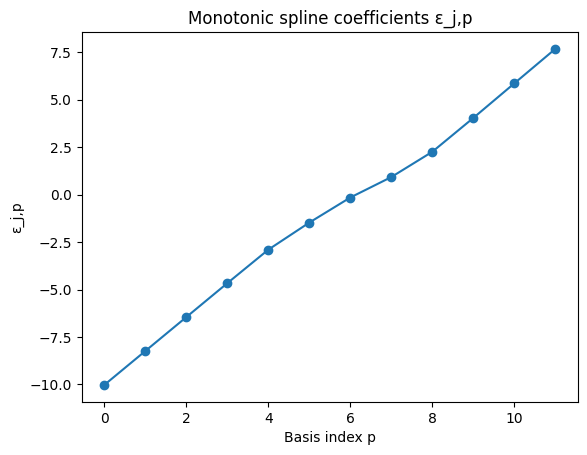

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-8.4950, -8.1256, -5.7837, -3.8298, -2.5412, -1.4563, -0.2014,  0.9867,
         2.0550,  2.1175,  2.1292,  2.1376])


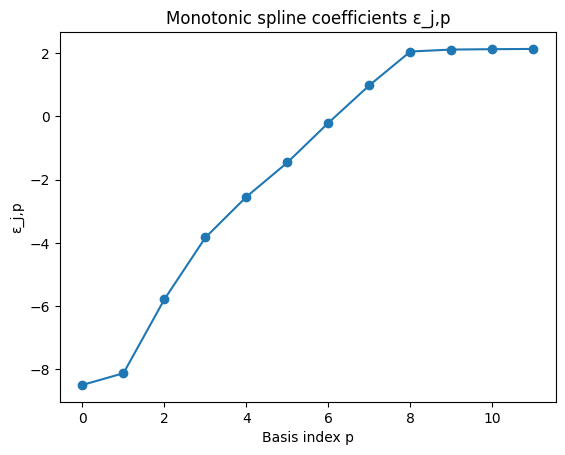

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-10.3047,  -8.7089,  -7.1131,  -5.5173,  -3.9087,  -0.8535,   3.2277,
          5.1843,   7.0025,   8.8207,  10.6389,  12.4571])


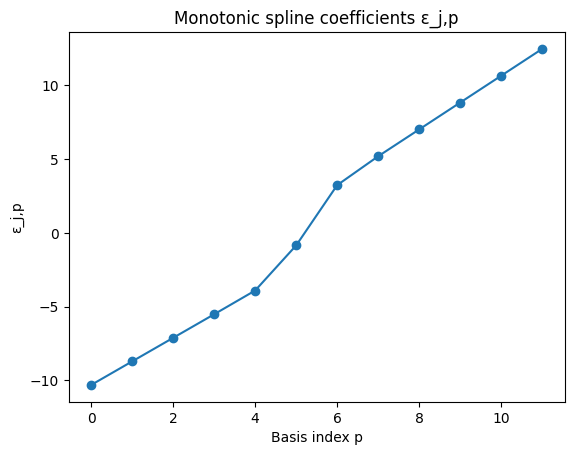

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-8.7991, -8.4878, -6.5504, -4.9687, -3.6957, -0.8578,  3.2207,  3.3982,
         3.4154,  3.4269,  3.4389,  3.4518])


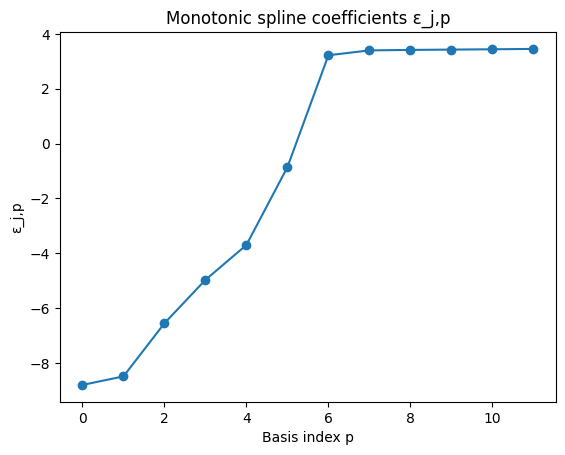

In [20]:
sanity_check(model_freq, transformation_grad=0)
sanity_check(model, transformation_grad=0)
sanity_check(model_freq, transformation_grad=1)
sanity_check(model, transformation_grad=1)

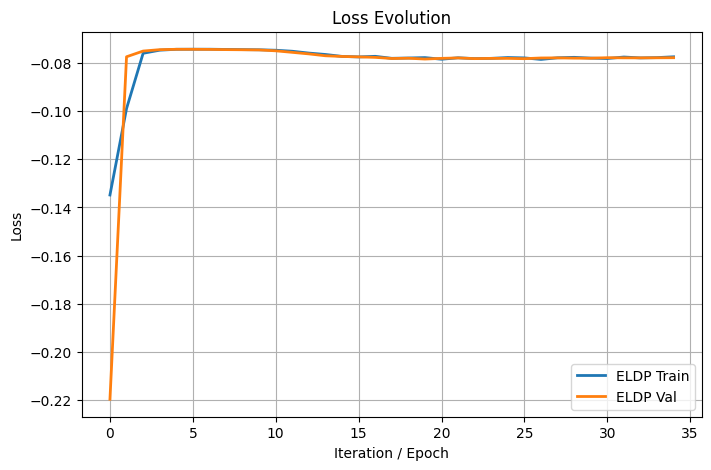

In [21]:
loss_history = output['ll_history']
val_loss = output['val_history']


# Plot            
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label="ELDP Train", linewidth=2)
plt.plot(val_loss, label="ELDP Val", linewidth=2)
plt.xlabel("Iteration / Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()
plt.grid(True)
plt.show()

In [22]:
log_likelihood_train_bgtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_bgtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_bgtm = model.log_likelihood(simulated_data_test)


log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [23]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)


In [24]:
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("")
print("KLD BGTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM      Train Data:  0.0242
KLD GTM      Train Data:  0.003
KLD Gaussian Train Data:  -0.0006
KLD Copula   Train Data:  -0.0005

KLD BGTM      Test  Data:  0.026
KLD GTM      Test  Data:  0.0067
KLD Gaussian Test  Data:  0.001
KLD Copula   Test  Data:  0.0009


In [27]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(100)
model_freq.approximate_transformation_inverse()
synthetic_samples_freq = model_freq.sample(100)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


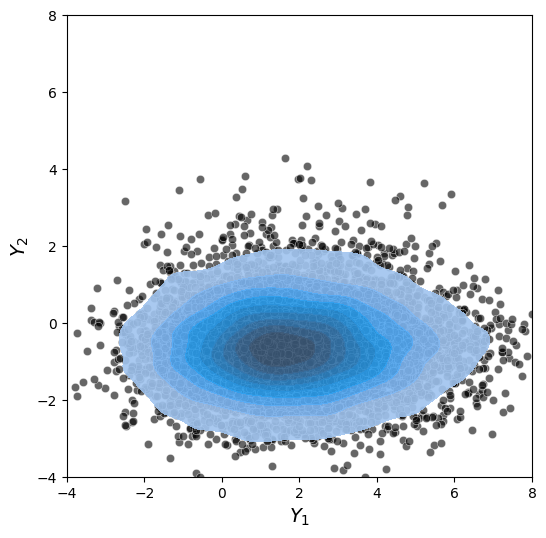

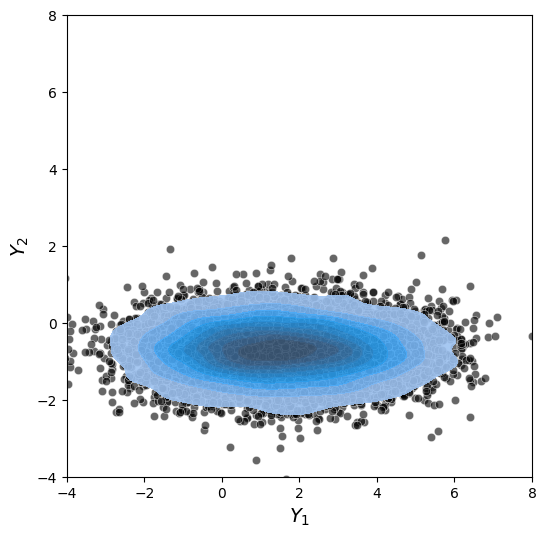

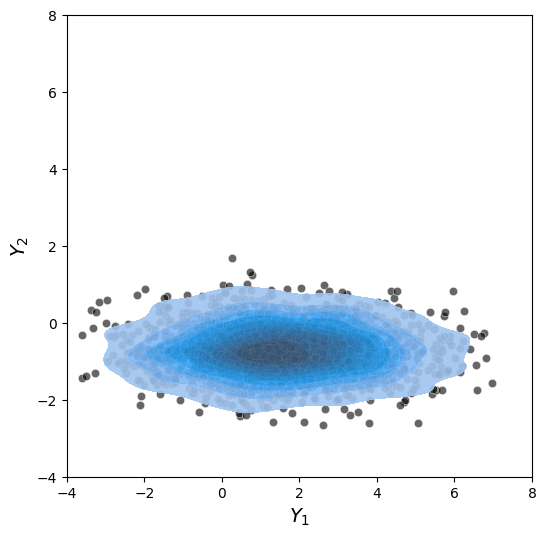

In [26]:
model.plot_densities(synthetic_samples.cpu().numpy(), x_lim=[-4,8], y_lim=[-4,8])
model_freq.plot_densities(synthetic_samples_freq, x_lim=[-4,8], y_lim=[-4,8])
model.plot_densities(simulated_data_train, x_lim=[-4,8], y_lim=[-4,8])

### Independence copula + two-component Gaussian mixture marginals (non-Gaussian)

In [37]:
import numpy as np
import torch
import pyvinecopulib as pv

# Mixture parameters per dimension (same weights across dims for simplicity)
w1 = 0.35  # w2 = 1 - w1
means = torch.tensor([[-2.0,  1.0],   # component 1 means per dim
                      [ 2.0, -1.0]],  # component 2 means per dim
                     dtype=torch.float32)
stds  = torch.tensor([[0.8, 0.5],
                      [0.6, 0.9]], dtype=torch.float32)

def gm2_icdf(u, w1, m, s):
    """
    u: [N, D] tensor in (0,1); w1 scalar; m,s: shape [2, D]
    Returns x: [N, D]
    """
    w2 = 1.0 - w1
    x = torch.empty_like(u)
    mask1 = (u < w1)
    u1 = torch.where(mask1, u / w1, torch.tensor(0.5, dtype=u.dtype))
    u2 = torch.where(~mask1, (u - w1) / w2, torch.tensor(0.5, dtype=u.dtype))
    # invert per dim
    for d in range(u.shape[1]):
        x1 = torch.distributions.Normal(m[0, d], s[0, d]).icdf(u1[:, d])
        x2 = torch.distributions.Normal(m[1, d], s[1, d]).icdf(u2[:, d])
        x[:, d] = torch.where(mask1[:, d], x1, x2)
    return x

def gm2_logpdf(x, w1, m, s):
    w2 = 1.0 - w1
    lp = torch.zeros(x.shape[0])
    for d in range(x.shape[1]):
        lp1 = torch.distributions.Normal(m[0, d], s[0, d]).log_prob(x[:, d])
        lp2 = torch.distributions.Normal(m[1, d], s[1, d]).log_prob(x[:, d])
        # log( w1*e^lp1 + w2*e^lp2 )
        a = torch.stack([lp1 + np.log(w1), lp2 + np.log(w2)], dim=1)
        lp += torch.logsumexp(a, dim=1)
    return lp

# ---------- Copula ----------
copula_pv = pv.Bicop(family=pv.BicopFamily.indep)

# ---------- Train ----------
N_train = 20000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
U_train = torch.tensor(simulated_data_uniform_train).float()
simulated_data_train = gm2_icdf(U_train, w1, means, stds)

# ---------- Validate ----------
N_validate = 20000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
U_val = torch.tensor(simulated_data_uniform_validate).float()
simulated_data_validate = gm2_icdf(U_val, w1, means, stds)

# ---------- Test ----------
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
U_test = torch.tensor(simulated_data_uniform_test).float()
simulated_data_test = gm2_icdf(U_test, w1, means, stds)

# ---------- "True" log-likelihoods under independence + GM(2) marginals ----------
loglik_true_train = gm2_logpdf(simulated_data_train, w1, means, stds)
loglik_true_validate = gm2_logpdf(simulated_data_validate, w1, means, stds)
loglik_true_test = gm2_logpdf(simulated_data_test, w1, means, stds)

# ---------- (Optional) crude "estimated" marginals ----------
# For mixtures, proper estimation needs EM or VI. If you just want a baseline,
# you could (very crudely) fit a single Gaussian to each dim:
means_est = simulated_data_train.mean(0)
stds_est  = simulated_data_train.std(0, unbiased=True)
loglik_true_est_train = torch.distributions.Normal(means_est, stds_est).log_prob(simulated_data_train).sum(1)
loglik_true_est_validate = torch.distributions.Normal(means_est, stds_est).log_prob(simulated_data_validate).sum(1)
loglik_true_est_test = torch.distributions.Normal(means_est, stds_est).log_prob(simulated_data_test).sum(1)
# (Use only as a rough reference; your transformation layer should beat this.)


In [38]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=20)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=20)

# BGTM

In [29]:
model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=0,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device="cpu",
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

model.transform_only = True

output = model.pretrain_transformation_layer(
                train_dataloader=dataloader_train,
                validate_dataloader=dataloader_validate,
                hyperparameters=None,
                iterations=200,
                #verbose=True,
                learning_rate=0.01,
                mcmc_sample_train=4,            # will ramp
                mcmc_sample_val=16,             # fixed & larger for stable eval
                mc_ramp_every=60,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=64,
                patience=30,                # early-stop patience
                min_delta=0.00001,                # ~0.1% absolute of your loss scale
                rho_lr_multiplier=0.5,          # slightly faster variance adaption (optional)
                sched_factor=0.7, sched_patience=8, sched_threshold=1e-4,
                #WARMING
                warm_tau_epochs = 3,
                warm_sigma_epochs = 10,  # try 5–10
                #Optimization method
                beta_kl_start= 1.5,    # try 1.5–3.0
                beta_kl_anneal_epochs = 15,  # how fast to decay to 1.0
            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


First 30 param keys: ['transformation.params.0', 'transformation.params.1']


  0%|          | 0/200 [00:00<?, ?it/s]

[sanity] N=20000  current B=20  (training objective uses scaled likelihood & unscaled prior)


# GTM

In [30]:

model_freq = GTM(
    number_variables = 2,
    number_transformation_layers = 1,
    number_decorrelation_layers = 0,
    degree_transformations = 10,
    degree_decorrelation = 40,
    spline_transformation = "bspline",
    spline_decorrelation = "bspline",
    transformation_spline_range = (-10, 10),
    device = "cpu") 

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            0,
                            0,
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False

# pretrain the marginal transformations
output_freq = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(2.0629, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7910, grad_fn=<MeanBackward0>)
current_loss: tensor(2.0270, grad_fn=<MeanBackward0>)
current_loss: tensor(1.9774, grad_fn=<MeanBackward0>)
current_loss: tensor(2.0002, grad_fn=<MeanBackward0>)
current_loss: tensor(1.9856, grad_fn=<MeanBackward0>)
current_loss: tensor(1.9283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.9033, grad_fn=<MeanBackward0>)
current_loss: tensor(2.1806, grad_fn=<MeanBackward0>)
current_loss: tensor(2.1297, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8265, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8042, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8059, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7390, grad_fn=<MeanBackward0>)
current_loss: tensor(1.9583, grad_fn=<MeanBackward0>)
current_loss: tensor(1.9432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7806, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7598, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7991,

  0%|          | 1/1000 [00:01<28:11,  1.69s/it]

current_loss: tensor(4.0436, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7201, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6499, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6257, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7257, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7125, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6241, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6186, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7479, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7755, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7744, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6831, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6821, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8356, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8333, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6867, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6748, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6376,

  0%|          | 2/1000 [00:03<27:45,  1.67s/it]

current_loss: tensor(1.7313, grad_fn=<MeanBackward0>)
current_loss: tensor(1.9307, grad_fn=<MeanBackward0>)
current_loss: tensor(1.9243, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7818, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7465, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6307, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6060, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6844, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6789, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6102, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6064, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7365, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7349, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7610, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7605, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6636, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6631, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8187,

  0%|          | 3/1000 [00:04<27:19,  1.64s/it]

current_loss: tensor(1.7205, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7099, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6013, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5924, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6658, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5808, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5794, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7172, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7161, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7118, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7455, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7450, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6437, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6433, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6410, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8079, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8023, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391,

  0%|          | 4/1000 [00:06<27:28,  1.66s/it]

current_loss: tensor(1.6986, grad_fn=<MeanBackward0>)
current_loss: tensor(1.9060, grad_fn=<MeanBackward0>)
current_loss: tensor(1.9016, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7638, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7982, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7496, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6039, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5800, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6532, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5732, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5695, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7054, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7033, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7360, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7356, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6329, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6323, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6296,

  0%|          | 5/1000 [00:08<27:10,  1.64s/it]

current_loss: tensor(1.6931, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6177, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5903, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6762, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6577, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5816, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5602, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7027, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6931, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7313, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7309, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6296, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6281, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7961, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7935, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6561, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6506, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6022,

  1%|          | 6/1000 [00:09<26:55,  1.62s/it]

current_loss: tensor(1.5977, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5963, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6605, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6567, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6317, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8034, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7839, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7867, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7763, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7256, grad_fn=<MeanBackward0>)
current_loss: tensor(2.3705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7147, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7776, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7561, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6828, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6820, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6783,

  1%|          | 7/1000 [00:11<26:50,  1.62s/it]

current_loss: tensor(1.6865, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6212, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7821, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7756, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7983, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7885, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7214, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8188, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7158, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5462, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5450, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6828, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6703, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8810, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8774, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7317, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6851,

  1%|          | 8/1000 [00:13<26:43,  1.62s/it]

current_loss: tensor(1.7832, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7091, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7080, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7751, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7670, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5401, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5395, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5365, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6723, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6692, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8839, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8764, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7275, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6952, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5957, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5760, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6613, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6476, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5595,

  1%|          | 8/1000 [00:14<30:19,  1.83s/it]

current_loss: tensor(1.7740, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5355, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5350, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6783, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6716, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8898, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8744, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7115, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6880, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6161, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5807, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6591, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6387, grad_fn=<MeanBackward0>)
Early Stop at iteration 8 with minimal loss tensor(1.6590, grad_fn=<MeanBackward0>) and patience 5 and min_delta 1e-07


dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-9.8111, -7.8667, -5.9222, -3.9758, -1.7420, -0.6234, -0.4363,  1.7888,
         4.0928,  5.9120,  7.7302,  9.5483])


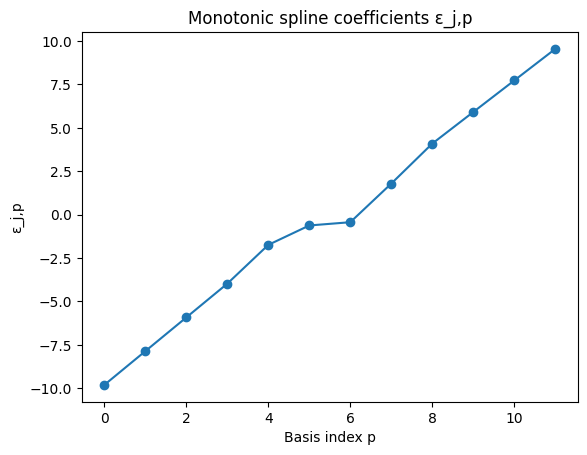

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-8.4473, -8.1130, -5.7330, -3.6320, -1.6367, -0.5480, -0.3897,  1.7734,
         4.2437,  4.2919,  4.2978,  4.3016])


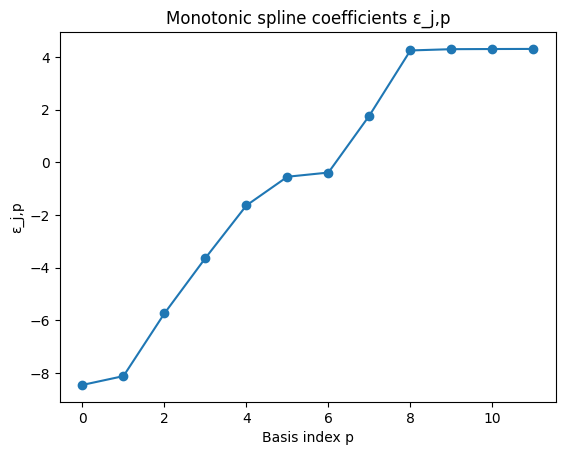

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-9.9639, -8.1296, -6.2953, -4.4606, -2.5831, -0.5023,  0.9510,  3.4297,
         5.2702,  7.0884,  8.9066, 10.7248])


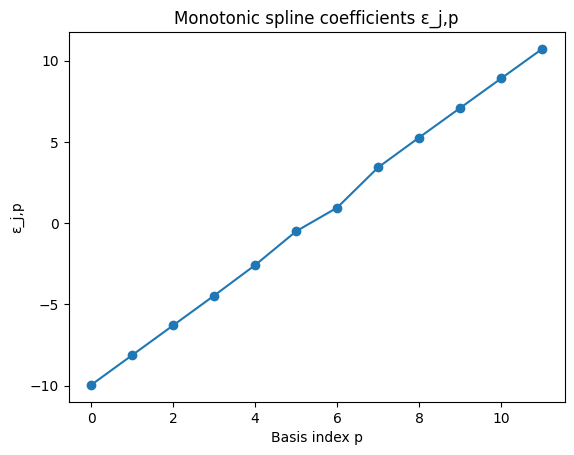

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-8.5459, -8.2343, -6.0003, -4.0698, -2.5404, -0.5785,  0.8742,  3.3903,
         3.4414,  3.4474,  3.4515,  3.4561])


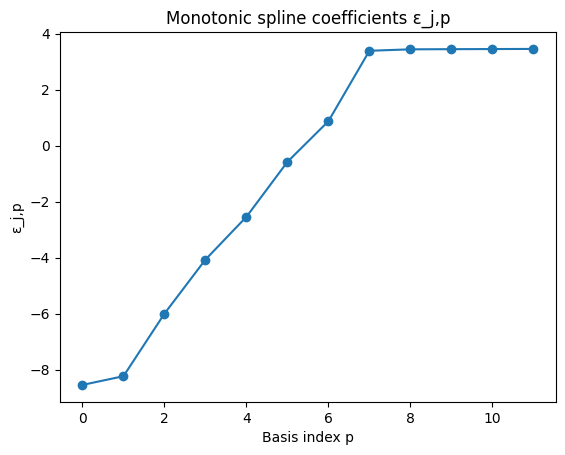

In [31]:
sanity_check(model_freq, transformation_grad=0)
sanity_check(model, transformation_grad=0)
sanity_check(model_freq, transformation_grad=1)
sanity_check(model, transformation_grad=1)

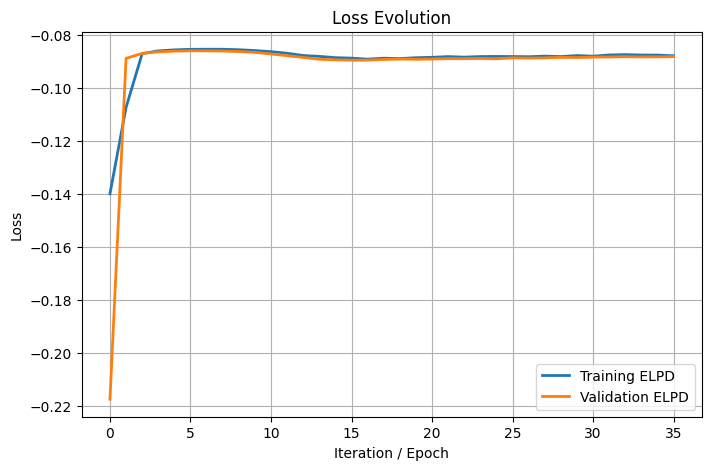

In [32]:
loss_history = output['ll_history']
val_loss = output['val_history']


# Plot            
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label="Training ELPD", linewidth=2)
plt.plot(val_loss, label="Validation ELPD", linewidth=2)
plt.xlabel("Iteration / Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()
plt.grid(True)
plt.show()

In [33]:
log_likelihood_train_bgtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_bgtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_bgtm = model.log_likelihood(simulated_data_test)


log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [34]:
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("")
print("KLD BGTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM      Train Data:  0.1886
KLD GTM      Train Data:  0.1878
KLD Gaussian Train Data:  -0.2636
KLD Copula   Train Data:  0.5218

KLD BGTM      Test  Data:  0.1858
KLD GTM      Test  Data:  0.1842
KLD Gaussian Test  Data:  -0.3068
KLD Copula   Test  Data:  0.5291


In [35]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)
model_freq.approximate_transformation_inverse()
synthetic_samples_freq = model_freq.sample(10000)

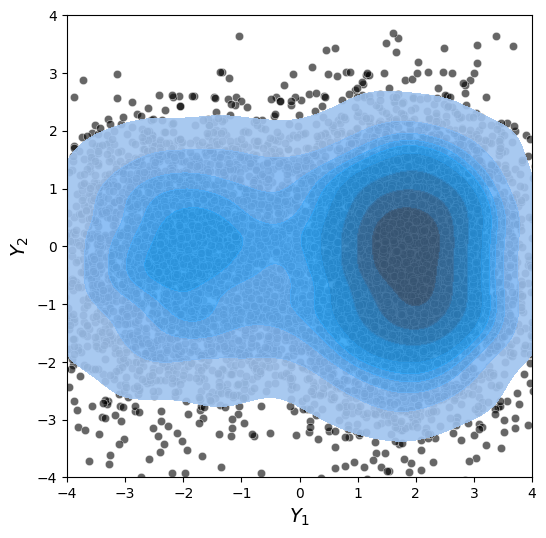

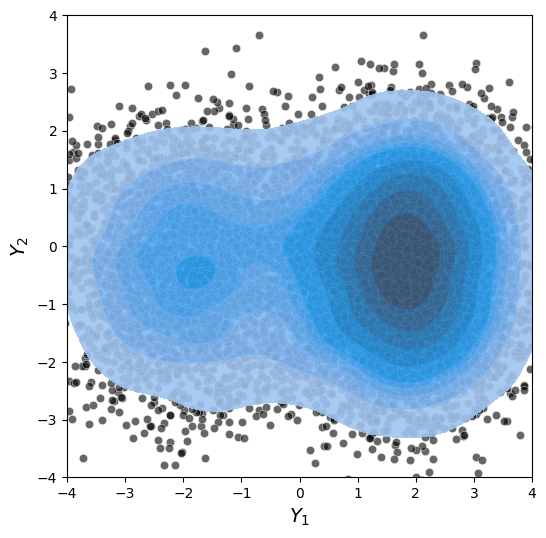

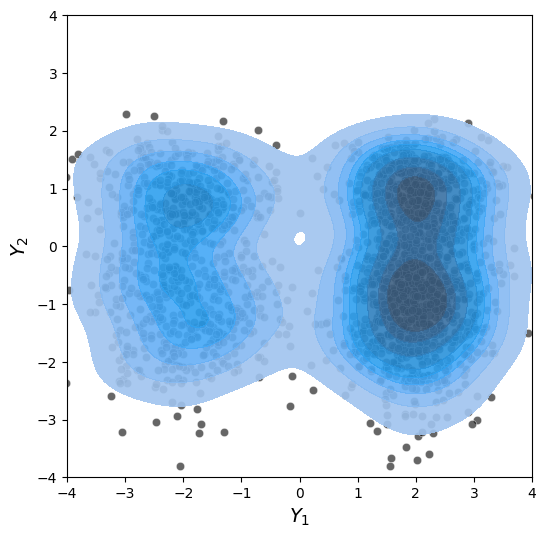

In [36]:
model.plot_densities(synthetic_samples, x_lim=[-4,4], y_lim=[-4,4])
model_freq.plot_densities(synthetic_samples_freq, x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])